#DFT as Neural Network

Discrete Fourier Transform (DFT) by a single layer neural network with a linear transfer function W.

A single layer network, with no bias, no activation function, and particular values for the weights.

The number of output nodes is equal to the number of frequencies we evaluate.

$\begin{align*}y_k &= \displaystyle \sum_{n=0}^{N-1} x_n \cdot \exp(-j\frac{2 \pi k}{N}n)\\
[y_0... y_{N-1}] &= [x_0... x_{N-1}]
\begin{bmatrix}
    \exp(0)     & \exp(0)                     & \exp(0)                      & \dots  & \exp(0) \\
    \exp(0)     & \exp(-i\frac{2\pi}{N})      & \exp(-i\frac{2\pi2}{N})      & \dots  & \exp(-i\frac{2\pi(N-1)}{N}) \\
    \exp(0)     & \exp(-i\frac{2\pi}{N}2)     & \exp(-i\frac{2\pi2}{N}2)     & \dots  & \exp(-i\frac{2\pi(N-1)}{N}2)\\ 
    \exp(0)     & \exp(-i\frac{2\pi}{N}3)     & \exp(-i\frac{2\pi2}{N}3)     & \dots  & \exp(-i\frac{2\pi(N-1)}{N}3)\\ 
    \vdots      & \vdots                      & \vdots                       &        & \vdots \\
    \exp(0)     & \exp(-i\frac{2\pi}{N}(N-1)) & \exp(-i\frac{2\pi2}{N}(N-1)) & \dots  & \exp(-i\frac{2\pi(N-1)}{N}(N-1))
\end{bmatrix}\\
\boldsymbol{y} &= \boldsymbol{x} W   
\end{align*}$



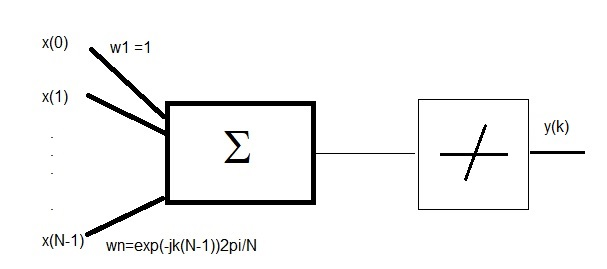

A single layer network, with no bias, no activation function, and particular values for the weights.

The number of output nodes is equal to the number of frequencies we evaluate.

# Learning the Fourier transform via gradient-descent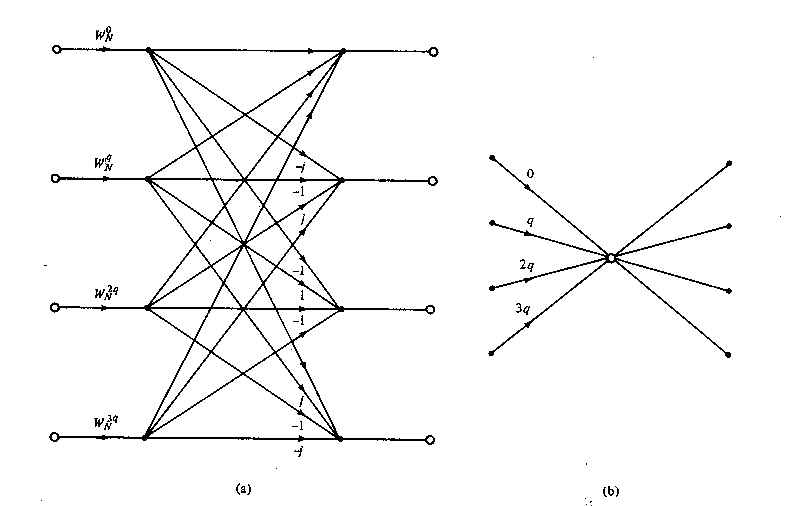

##Computing the Fourier transform using a set of Fourier weights

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_fourier_weights(signal_length):  
    "Create weights, as described above."
    k_vals, n_vals = np.mgrid[0:signal_length, 0:signal_length]
    theta_vals = 2 * np.pi * k_vals * n_vals / signal_length
    return np.hstack([np.cos(theta_vals), -np.sin(theta_vals)])


First half of inputs/outputs is real part, second half is imaginary part

$\exp(-j \frac{2 \pi k}{N}n) = cos(\frac{2 \pi k}{N}n) - j sin(\frac{2 \pi k}{N}n)$

In [3]:
# Generate data:
signal_length = 64
x = np.random.random(size=[1, signal_length]) - 0.5

# compare the above implementation with conventional FFT
## Compute Fourier transform using method described above:
W_fourier = create_fourier_weights(signal_length)
y = np.matmul(x, W_fourier)

# Compute Fourier transform using the fast Fourier transform: 
fft = np.fft.fft(x)
y_fft = np.hstack([fft.real, fft.imag])

# Compare the results:
print('rmse: ', np.sqrt(np.mean((y - y_fft)**2)))

rmse:  1.4679018157540228e-14


 checking  to reconstruct the signal:

rmse: 1.9814316506530526e-15


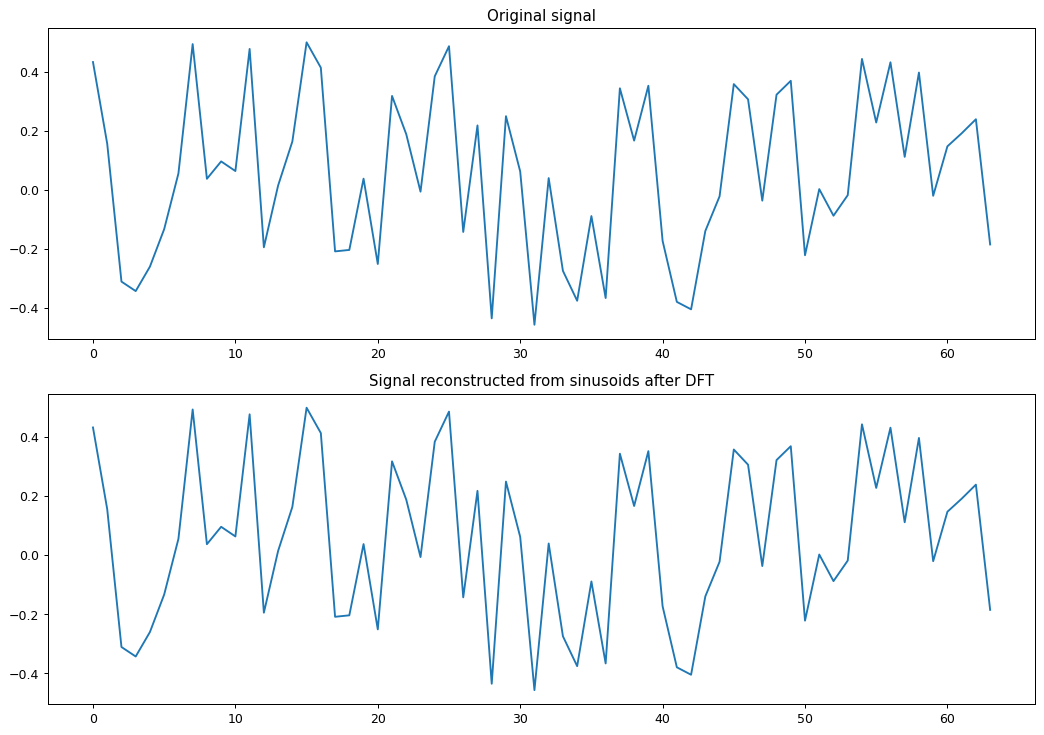

In [4]:
y_real = y[:, :signal_length]
y_imag = y[:, signal_length:]
tvals = np.arange(signal_length).reshape([-1, 1])
freqs = np.arange(signal_length).reshape([1, -1])
arg_vals = 2 * np.pi * tvals * freqs / signal_length
sinusoids = (y_real * np.cos(arg_vals) - y_imag * np.sin(arg_vals)) / signal_length
reconstructed_signal = np.sum(sinusoids, axis=1)

print('rmse:', np.sqrt(np.mean((x - reconstructed_signal)**2)))
plt.figure(figsize=(11.7,8.27), dpi=90)
plt.subplot(2, 1, 1)
plt.plot(x[0,:])
plt.title('Original signal')
plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal)
plt.title('Signal reconstructed from sinusoids after DFT')
plt.tight_layout()
plt.show()

## Learning the Fourier transform via gradient-descent

In [5]:
import tensorflow as tf

# Initialise weight vector to train:
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)

# Expected weights, for comparison:
W_expected = create_fourier_weights(signal_length)

losses = []
rmses = []

for i in range(1000):
    # Generate a random signal each iteration:
    x = np.random.random([1, signal_length]) - 0.5
    
    # Compute the expected result using the FFT:
    fft = np.fft.fft(x)
    y_true = np.hstack([fft.real, fft.imag])
    
    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        loss = tf.reduce_sum(tf.square(y_pred - y_true))
    
    # Train weights, via gradient descent:
    W_gradient = tape.gradient(loss, W_learned)    
    W_learned = tf.Variable(W_learned - 0.1 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected)**2)))

print('Final loss value =',loss,'inal weights´ rmse =',np.sqrt(np.mean((W_learned - W_expected)**2)))

Final loss value = tf.Tensor(0.0001744382616815298, shape=(), dtype=float64) inal weights´ rmse = 0.00042113171617393785


## Learning the Fourier transform via reconstruction

In [6]:
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)

tvals = np.arange(signal_length).reshape([-1, 1])
freqs = np.arange(signal_length).reshape([1, -1])
arg_vals = 2 * np.pi * tvals * freqs / signal_length
cos_vals = tf.cos(arg_vals) / signal_length
sin_vals = tf.sin(arg_vals) / signal_length

losses = []
rmses = []

for i in range(10000):
    x = np.random.random([1, signal_length]) - 0.5
    
    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        y_real = y_pred[:, 0:signal_length]
        y_imag = y_pred[:, signal_length:]
        sinusoids = y_real * cos_vals - y_imag * sin_vals
        reconstructed_signal = tf.reduce_sum(sinusoids, axis=1)
        loss = tf.reduce_sum(tf.square(x - reconstructed_signal))

    W_gradient = tape.gradient(loss, W_learned)    
    W_learned = tf.Variable(W_learned - 0.5 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected)**2)))

print('Final loss value =',loss,'inal weights´ rmse =',np.sqrt(np.mean((W_learned - W_expected)**2)))

Final loss value = tf.Tensor(6.089961938761829e-11, shape=(), dtype=float64) inal weights´ rmse = 0.2027060677393045


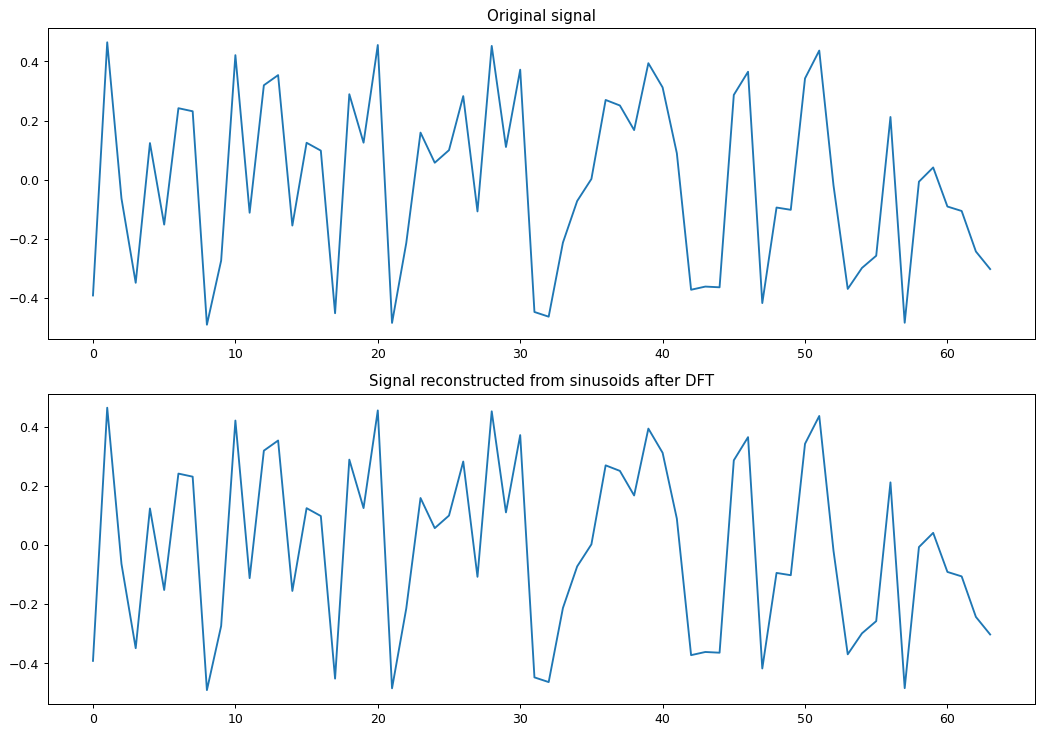

In [7]:
plt.figure(figsize=(11.7,8.27), dpi=90)
plt.subplot(2, 1, 1)
plt.plot(x[0,:])
plt.title('Original signal')
plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal)
plt.title('Signal reconstructed from sinusoids after DFT')
plt.tight_layout()
plt.show()



1.   https://sidsite.com/posts/fourier-nets/
2.   

